# HCM Legionella Project

## Set-up and Cleaning Data

### Importing Need Libraries

In [3]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import sqlite3
from scipy.stats import chi2_contingency
import statsmodels.api as sm

### Making needed functions

In [4]:
def view_df(subfolder, filename):
    filepath = f"{subfolder}/{filename}"
    df = pd.read_csv(filepath)
    print(df.head())

def data_review(name,subfolder, filename, groupby_col):
    filepath = f"{subfolder}/{filename}"
    df = pd.read_csv(filepath)
    df_count = df.groupby([groupby_col]).size().reset_index(name='counts')
    df_count.sort_values(by='counts', ascending=False, inplace=True)
    if df.isnull().any().any():
        null_counts = df[groupby_col].isnull().sum()
        print("Legionella",name,"\n")
        print(df_count)
        print(f"Null count: {null_counts}")
    else:
        print("Legionella",name,"\n", df_count)



### Data Overview

In [5]:
# Review of all labs data
all_labs = pd.read_csv('raw_data/legionella_all_labs.csv')
component_name_counts = all_labs.groupby(['loinc_name', 'loinc_code']).size().reset_index(name='counts')
component_name_counts.sort_values(by='counts', ascending=False, inplace=True)
print(component_name_counts)

                   loinc_name loinc_code  counts
2            Legionella sp Ag    32781-7   52431
1  Legionella pneumophila DNA    92969-5   11197
0   Legionella pneumophila Ab    30046-7    5296


### Cleaning Data

#### Cleaning Legionella Urine Antigen Data

In [6]:
# Mutilple wasy legionella urine antigen test result is represented in the data
data_review('Raw Urine Antigen','raw_data', 'legionella_urine_ag.csv','test_result')

Legionella Raw Urine Antigen 
       test_result  counts
592      Negative   47656
595      Positive     292
593  Not Detected     121
144          0.65      69
125          0.61      63
..            ...     ...
306         1.067       1
305         1.065       1
304         1.063       1
82          0.484       1
0               *       1

[603 rows x 2 columns]


In [7]:
# Legionella Urine Antigen Cleaning

urine_ag_drop_value_list = [
    'SEE NOTE',
    'Test Cancelled by Lab',
    'TNP',
    'See separate report. Scanned results can also be viewed in EPIC.',
    'See Notes',
    'NOT ESTABLISHED',
    '*'
]

urine_ag_negative_replace_dict = {
    'Not Detected': 'negative',
    'NEGATIVE': 'negative',
    'NEG': 'negative',
    'Not-Detected': 'negative',
    'Negative': 'negative',
}

urine_ag_positive_replace_dict = {
    '>51.72': 'positive',
    'WEAK POSITIVE CONFIRMED BY REPEAT TESTING': 'positive',
    'Weak positive reaction. It was repeated to confirm. Please resubmit new sample for testing if clnically indicated.': 'positive',
    '>62.5': 'positive',
    '>58.82': 'positive',
    'Detected': 'positive',
    'Positive': 'positive',
}

# Clean the DataFrame
urine_antigen = pd.read_csv('raw_data/legionella_urine_ag.csv')

df_cleaned_urine = urine_antigen[~urine_antigen['test_result'].isin(urine_ag_drop_value_list)].copy()
df_cleaned_urine['test_result'] = df_cleaned_urine['test_result'].replace(urine_ag_negative_replace_dict)
df_cleaned_urine['test_result'] = df_cleaned_urine['test_result'].replace(urine_ag_positive_replace_dict)

# Split the DataFrame into two DataFrames for string and numeric values
df_cleaned_urine_string_value = df_cleaned_urine.loc[(df_cleaned_urine['test_result'] == 'positive') | (df_cleaned_urine['test_result'] == 'negative')].copy()
df_cleaned_urine_numeric_value = df_cleaned_urine.loc[(df_cleaned_urine['test_result'] != 'positive') & (df_cleaned_urine['test_result'] != 'negative')].copy()

# Convert the numeric values to positive or negative
df_cleaned_urine_numeric_value['test_result'] = df_cleaned_urine_numeric_value['test_result'].astype(float)
df_cleaned_urine_numeric_value['test_result'] = df_cleaned_urine_numeric_value['test_result'].apply(lambda x: 'positive' if x > 1 else 'negative')

# Concatenate the two DataFrames
df_urine_combined = pd.concat([df_cleaned_urine_string_value, df_cleaned_urine_numeric_value])

#Add test name column
df_urine_combined.insert(1, 'test_name', 'urine_ag')

# Ensure the result_time column is in datetime format
df_urine_combined['result_time'] = pd.to_datetime(df_urine_combined['result_time'], errors='coerce')

# Simplify date/time column to date column
df_urine_combined['result_time'] = df_urine_combined['result_time'].dt.date

# Reset the index
df_urine_combined.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame
df_urine_combined.to_csv('cleaned_data/urine_antigen.csv', index=False)

In [8]:
# Review the cleaned DataFrame
view_df('cleaned_data', 'urine_antigen.csv')

                enc_id test_name test_result result_time
0 -7312314944888346835  urine_ag    negative  2019-01-02
1 -2008937158608661587  urine_ag    negative  2024-03-02
2  3401803940007298938  urine_ag    negative  2023-01-11
3  5511838379406484453  urine_ag    negative  2022-02-13
4  8460582827627321790  urine_ag    negative  2023-06-19


In [9]:
data_review('Cleaned Urine Antigen','cleaned_data', 'urine_antigen.csv','test_result')

Legionella Cleaned Urine Antigen 
   test_result  counts
0    negative   51108
1    positive    1311


#### Cleaning Legionella PCR Data

In [10]:
# Initial review of test results indictors in the raw PCR data
data_review('Raw PCR Data','raw_data','legionella_pcr.csv','test_result')

Legionella Raw PCR Data 
     test_result  counts
1  Not-Detected   11134
0      Detected      63


In [11]:
# Legionella PCR Cleaning

legionella_pcr_data = pd.read_csv('raw_data/legionella_pcr.csv')
legionella_pcr_data['test_result'] = legionella_pcr_data['test_result'].replace({'Not-Detected': 'negative', 'Detected': 'positive'})

# Simple date/time column to date column
legionella_pcr_data['result_time'] = pd.to_datetime(legionella_pcr_data['result_time'], errors='coerce')
legionella_pcr_data['result_time'] = legionella_pcr_data['result_time'].dt.date

# Add test name column
legionella_pcr_data.insert(1, 'test_name', 'pcr')

# Save cleaned data
legionella_pcr_data.reset_index(drop=True, inplace=True)
legionella_pcr_data.to_csv('cleaned_data/pcr.csv', index=False)

In [12]:
view_df('cleaned_data', 'pcr.csv')

                enc_id test_name test_result result_time
0 -7831529689728217722       pcr    negative  2022-08-09
1  5820017167947140067       pcr    negative  2022-05-17
2  4761646286486635340       pcr    negative  2022-08-26
3  4241844073832949387       pcr    negative  2022-06-03
4 -5908285111359128859       pcr    negative  2022-06-05


In [13]:
data_review('Cleaned PCR','cleaned_data', 'pcr.csv','test_result')

Legionella Cleaned PCR 
   test_result  counts
0    negative   11134
1    positive      63


#### Cleaning Legionella Antibody Data

In [14]:
data_review('Raw Antibody Data','raw_data', 'legionella_ab.csv','test_result')

Legionella Raw Antibody Data 

  test_result  counts
0        High     743
Null count: 4177


In [15]:
#Cleaning Legionella Antibody Data

#Import the data and update tests results to positive and negative
legionella_abs = pd.read_csv('raw_data/legionella_ab.csv')
legionella_abs.loc[legionella_abs["test_result"] == "High", "test_result"] = "positive"
legionella_abs.fillna('negative', inplace=True)

# Simplify date/time column to date column
legionella_abs['result_time'] = pd.to_datetime(legionella_abs['result_time'], errors='coerce')
legionella_abs['result_time'] = legionella_abs['result_time'].dt.date

# Add test name column
legionella_abs.insert(1, 'test_name', 'antibody')

legionella_abs.reset_index(drop=True, inplace=True)

legionella_abs.to_csv('cleaned_data/abs.csv', index=False)

In [16]:
view_df('cleaned_data', 'abs.csv')

                enc_id test_name test_result result_time
0  4788652119311449749  antibody    negative  2014-02-09
1   473527142110099312  antibody    negative  2014-02-27
2  2916569464947500530  antibody    negative  2012-06-26
3  6645247072530359702  antibody    negative  2012-07-27
4  2293010662835670076  antibody    negative  2013-10-17


In [17]:
data_review('Cleaned Antibody','cleaned_data', 'abs.csv','test_result')

Legionella Cleaned Antibody 
   test_result  counts
0    negative    4177
1    positive     743


#### Cleaning encounter and patient data

In [18]:
def list_col_unique_values(filepath, col_name):
    df = pd.read_csv(filepath)
    unique_values = df[col_name].unique().tolist()
    return unique_values

def diff_btw_two_lists(list1, list2):
    diff = list(set(list1) - set(list2))
    return diff

In [19]:
# Read the CSV file'
enc_id_pt_id = pd.read_csv('raw_data/legionella_enc_id_pt_id.csv')
enc_id_pt_id_list = list_col_unique_values('raw_data/legionella_enc_id_pt_id.csv', 'enc_id')
print(f'Length of raw data list: {len(enc_id_pt_id_list)}')

# Concatenate DataFrames vertically
df_combined = pd.concat([df_urine_combined, legionella_pcr_data, legionella_abs], axis=0)

# Get the list of unique values in the 'enc_id' column
df_combined_list = df_combined['enc_id'].unique().tolist()
print(f'Length of combined data list: {len(df_combined_list)}')


Length of raw data list: 55472
Length of combined data list: 55369


In [20]:
# Find values that are in list1 but not in list2
diff_list1 = diff_btw_two_lists(enc_id_pt_id_list, df_combined_list)
print(f'Number of encounters more in raw data than cleaned data: {len(diff_list1)}')

# Find values that are in list2 but not in list1
diff_list2 = diff_btw_two_lists(df_combined_list,enc_id_pt_id_list)
print(f'Number of encounters more in cleaned data than raw data: {len(diff_list2)}')


Number of encounters more in raw data than cleaned data: 103
Number of encounters more in cleaned data than raw data: 0


Appears raw data picked up 103 incidences where patients were tested without a patient encounter assigned

In [21]:
# Filter the DataFrame for encounters that are in the test list
enc_id_pt_id = enc_id_pt_id[enc_id_pt_id['enc_id'].isin(df_combined_list)]

enc_id_pt_id.to_csv('cleaned_data/enc_id_pt_id.csv', index=False)

In [22]:
view_df('cleaned_data', 'enc_id_pt_id.csv')

                enc_id                pt_id
0  3975049077239673395 -2809235875882990763
1 -5061831035098387866  5854567137542095248
2  6552655377892982779 -6367218150678696176
3 -3027420987132274233 -3367994639189120993
4 -7079776670532774587 -5049807079949078850


#### Cleaning Patient Data

In [23]:
# Review the patient raw data
view_df('raw_data', 'legionella_pt.csv')

                 pt_id age     sex                       ethnicity  \
0  3013939574033803906  84    Male  Not of Spanish/Hispanic Origin   
1 -4955299412922112414  88  Female  Not of Spanish/Hispanic Origin   
2 -4690851033038895663  18    Male            Prefer not to answer   
3 -7660776755063619649   7  Female            Prefer not to answer   
4  2390066754025880690  59  Female                        Honduran   

                            race  
0      Black or African American  
1                          White  
2  Hispanic or Latino or Spanish  
3           Prefer not to answer  
4                     Not listed  


In [24]:
# Review the patient sex data
data_review('Patient Data','raw_data', 'legionella_pt.csv','sex')

Legionella Patient Data 

       sex  counts
1     Male   22465
0   Female   19544
3        X       5
2  Unknown       1
Null count: 1


In [25]:
# Review the patient age data
data_review('Patient Data','raw_data', 'legionella_pt.csv','age')

Legionella Patient Data 

            age  counts
89  90 or older    7928
75           77    1116
74           76    1016
73           75     957
81           82     946
..          ...     ...
10           18      25
6            14      24
3            11      23
7            15      20
0             0       8

[90 rows x 2 columns]
Null count: 0


In [26]:
# Import the patient data
df_pt = pd.read_csv('raw_data/legionella_pt.csv')

# Drop the 'ethnicity' and 'race' columns as too many values many values to be cleaned
df_pt = df_pt.drop(columns=['ethnicity'])
df_pt = df_pt.drop(columns=['race'])

# Correct 'sex' columm
df_pt = df_pt.dropna(subset=['sex'])
values_to_drop = ['X', 'Unknown']
df_pt = df_pt[~df_pt['sex'].isin(values_to_drop)]

# Correct the 'age' column and convert it to an integer
df_pt['age'] = df_pt['age'].apply(lambda x: '90' if x == '90 or older' else str(x))
df_pt['age'] = df_pt['age'].astype(int)

# Make an age bucket column
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69', '70-79', '80-89', '90+']
df_pt['age_bucket'] = pd.cut(df_pt['age'], bins=bins, labels=labels, right=False)

# Reindex the DataFrame with the new column order
df_pt = df_pt[['pt_id', 'sex', 'age', 'age_bucket']]

# Reset the index
df_pt = df_pt.reset_index(drop=True)

# Save the cleaned DataFrame
df_pt.to_csv('cleaned_data/patient.csv', index=False)

In [27]:
# Review cleaned patient data
view_df('cleaned_data', 'patient.csv')

                 pt_id     sex  age age_bucket
0  3013939574033803906    Male   84      80-89
1 -4955299412922112414  Female   88      80-89
2 -4690851033038895663    Male   18      10-19
3 -7660776755063619649  Female    7        0-9
4  2390066754025880690  Female   59      50-59


#### Cleaning Encounter Data

In [28]:
# Review the encounter data
view_df('raw_data', 'legionella_enc.csv')

                enc_id  enc_year            enc_type
0 -2351246031288901868      2023  Hospital Encounter
1  7737624844017017966      2023  Hospital Encounter
2  8126526588940491562      2024  Hospital Encounter
3 -3569220862922256511      2015        Office Visit
4   963918296760474661      2015  Hospital Encounter


In [29]:
# Review the encounter type data in encounter data
data_review('Patient Data','raw_data', 'legionella_enc.csv','enc_type')

Legionella Patient Data 
                            enc_type  counts
3                Hospital Encounter   54670
5                      Office Visit     472
8                         PFT Visit     141
6                       Orders Only      72
4                         Lab Visit      50
0                       Appointment      44
12                        Telephone       8
10                     Telemedicine       5
11  Telemedicine Clinical Encounter       3
1                  Clinical Support       2
9                   Patient Message       2
2                         Follow-Up       1
7          Outpatient Therapy Visit       1
13                Weekly Evaluation       1


In [30]:
# Import the encounter data
df_enc = pd.read_csv('raw_data/legionella_enc.csv')

# Filter for only data that is in the cleaned list
enc_clean_list = list_col_unique_values('cleaned_data/enc_id_pt_id.csv', 'enc_id')
df_enc = df_enc[df_enc['enc_id'].isin(enc_clean_list)]

# Make encounter type binary (inpatient vs outpatient)
df_enc['enc_type'] = df_enc['enc_type'].apply(lambda x: 'inpatient' if x == 'Hospital Encounter' else 'outpatient')

# Ensure the 'enc_date' column is in datetime format
df_enc['enc_year'] = pd.to_datetime(df_enc['enc_year'], format='%Y')
df_enc['enc_year'] = df_enc['enc_year'].dt.year


# Reset the index
df_enc = df_enc.reset_index(drop=True)

# Save the cleaned DataFrame
df_enc.to_csv('cleaned_data/encounter.csv', index=False)

In [31]:
# Review the cleaned DataFrame
view_df('cleaned_data', 'encounter.csv')

                enc_id  enc_year    enc_type
0 -2351246031288901868      2023   inpatient
1  7737624844017017966      2023   inpatient
2  8126526588940491562      2024   inpatient
3 -3569220862922256511      2015  outpatient
4   963918296760474661      2015   inpatient


In [32]:
data_review('Cleaned encounter','cleaned_data', 'encounter.csv','enc_type')

Legionella Cleaned encounter 
      enc_type  counts
0   inpatient   54621
1  outpatient     748


#### Clean Diagnosis Data

In [33]:
#Number of possible diagnosis per encounter
data_review('Patient Data','raw_data', 'legionella_dx.csv','dx_name')

Legionella Patient Data 
                                       dx_name  counts
14541                            Hypertension    8899
1710   Acute respiratory failure with hypoxia    5987
14476                          Hyperlipidemia    5855
92                  AKI (acute kidney injury)    4055
22800         Pneumonia due to COVID-19 virus    3660
...                                       ...     ...
14333                     Hx of scarlet fever       1
14335                   Hx of self mutilation       1
14336                  Hx of septic arthritis       1
14337                 Hx of sinus tachycardia       1
15319             Infection of cervical spine       1

[30638 rows x 2 columns]


In [34]:
df_dx = pd.read_csv('raw_data/legionella_dx.csv')

most_common_values = df_dx['dx_name'].value_counts()

# Convert to a list of tuples (value, count)
most_common_list = list(most_common_values.items())

most_common_list.sort(key=lambda x: x[1], reverse=True)
most_common_list

[('Hypertension', 8899),
 ('Acute respiratory failure with hypoxia', 5987),
 ('Hyperlipidemia', 5855),
 ('AKI (acute kidney injury)', 4055),
 ('Pneumonia due to COVID-19 virus', 3660),
 ('Pneumonia', 3083),
 ('Diabetes mellitus', 2984),
 ('COPD (chronic obstructive pulmonary disease)', 2783),
 ('Hypokalemia', 2661),
 ('GERD (gastroesophageal reflux disease)', 2519),
 ('CAD (coronary artery disease)', 2503),
 ('Hyperlipidemia, unspecified', 2459),
 ('Sepsis', 2297),
 ('Asthma', 2284),
 ('Acute kidney failure, unspecified', 2141),
 ('Hyponatremia', 2112),
 ('Septic shock', 2073),
 ('Contact with and (suspected) exposure to covid-19', 2041),
 ('Anemia', 1972),
 ('Hyperkalemia', 1957),
 ('Hypothyroidism', 1926),
 ('Other disorders of plasma-protein metabolism, not elsewhere classified',
  1838),
 ('Atrial fibrillation', 1814),
 ('Hypo-osmolality and hyponatremia', 1772),
 ('Depression', 1760),
 ('Arthritis', 1758),
 ('Personal history of nicotine dependence', 1745),
 ('Pneumonia due to org

In [35]:
# Read the CSV file
df_dx = pd.read_csv('raw_data/legionella_dx.csv')

# Filter for only data that is in the cleaned list
enc_clean_list = list_col_unique_values('cleaned_data/enc_id_pt_id.csv', 'enc_id')
df_dx = df_dx[df_dx['enc_id'].isin(enc_clean_list)]

# Randomly sample 1 row of each encounter
#df_dx = df_dx.sample(frac=1).reset_index(drop=True)
#df_dx = df_dx.drop_duplicates(subset='enc_id')

# Make lowercase
df_dx['dx_name'] = df_dx['dx_name'].str.lower()

# Dictionary of replacement terms to consolidate by organ system
replace_dict = {
    'covid': 'pulmonary_abnormality',
    'coronavirus': 'pulmonary_abnormality',
    'pneumonia': 'pulmonary_abnormality',
    'respiratory infection': 'pulmonary_abnormality',
    'respiratory failure' : 'pulmonary_abnormality',
    'shortness of breath' : 'pulmonary_abnormality',
    'emphysema' : 'pulmonary_abnormality',
    'dyspnea': 'pulmonary_abnormality',
    'hypoxemia': 'pulmonary_abnormality',
    'hypoxia': 'pulmonary_abnormality',
    'hemoptysis': 'pulmonary_abnormality',
    'asthma': 'pulmonary_abnormality',
    'atelectasis': 'pulmonary_abnormality',
    'apnea': 'pulmonary_abnormality',
    'copd': 'pulmonary_abnormality',
    'pneumothorax': 'pulmonary_abnormality',
    'pneumonitis': 'pulmonary_abnormality',
    'cough': 'pulmonary_abnormality',
    'supplemental oxygen': 'pulmonary_abnormality',
    'pleural effusion': 'pulmonary_abnormality',
    'pulmonary edema': 'pulmonary_abnormality',
    'lung cancer': 'pulmonary_abnormality',
    'influenza a': 'pulmonary_abnormality',

    'sepsis': 'sepsis',
    'septic' : 'sepsis',
    'shock' : 'sepsis',
    'fever': 'sepsis',

    'hyperlipidemia': 'cardiac_abnormality',
    'hypercholesterolemia': 'cardiac_abnormality',
    'a-fib': 'cardiac_abnormality',
    'hypertension': 'cardiac_abnormality',
    'hypotension': 'cardiac_abnormality',
    'cad': 'cardiac_abnormality',
    'heart': 'cardiac_abnormality',
    'coronary artery disease': 'cardiac_abnormality',
    'atrial fibrillation': 'cardiac_abnormality',
    'congestive heart failure': 'cardiac_abnormality',
    'cardiac arrest': 'cardiac_abnormality',
    'chf': 'cardiac_abnormality',
    'nstemi': 'cardiac_abnormality',
    'troponin': 'cardiac_abnormality',
    'cardia': 'cardiac_abnormality',
    'cardio': 'cardiac_abnormality',
    'coronary angioplasty': 'cardiac_abnormality',
    'arrhythmia': 'cardiac_abnormality',
    'pacemaker': 'cardiac_abnormality',

    'kidney': 'renal_abnormality',
    'renal': 'renal_abnormality',
    'dehydration': 'renal_abnormality',
    'kalemia':'renal_abnormality',
    'natremia':'renal_abnormality',
    'calcemia':'renal_abnormality',
    'magnesemia':'renal_abnormality',
    'acidosis':'renal_abnormality',
    'alkalosis':'renal_abnormality',

    'gerd': 'gi_abnormality',
    'gastro-esophageal': 'gi_abnormality',
    'gastroesophageal': 'gi_abnormality',
    'gastroesophageal reflux disease': 'gi_abnormality',
    'dysphagia': 'gi_abnormality',
    'constipation': 'gi_abnormality',

    'anemia':'hematologic_abnormality',
    'cytosis':'hematologic_abnormality',
    'leukopenia':'hematologic_abnormality',
    'cytopenia':'hematologic_abnormality',
    'dvt':'hematologic_abnormality',
    'aspirin ':'hematologic_abnormality',
    'use of anticoagulants':'hematologic_abnormality',
    'long term (current) use of aspirin':'hematologic_abnormality',

    'diabetes': 'endocrine_abnormality',
    'thyroid':'endocrine_abnormality',
    'glycemia':'endocrine_abnormality',
    'obesity':'endocrine_abnormality',
    'insulin':'endocrine_abnormality',
    'hormone':'endocrine_abnormality',
    
    'arthritis':'rheumatolic_abnormality',
    'osteoporosis':'rheumatolic_abnormality',
    'gout':'rheumatolic_abnormality',
    
    'gait disorder':'neurologic_abnormality',
    'tia':'neurologic_abnormality',
    'stroke':'neurologic_abnormality',
    'dementia':'neurologic_abnormality',
    'seizures':'neurologic_abnormality',
    'encephalopathy':'neurologic_abnormality',
    'mental status':'neurologic_abnormality',
    'weakness':'neurologic_abnormality',
    
    'bph':'urologic_abnormality',
    'uti':'urologic_abnormality',
    'prostat':'urologic_abnormality',
    'urinary tract infection':'urologic_abnormality',

    'palliative':'end_of_life_care',
    'hospice':'end_of_life_care',
    'do not resuscitate':'end_of_life_care',
    'goals of care':'end_of_life_care',
    'advance directive':'end_of_life_care',
    'age-related':'end_of_life_care',
    'debility':'end_of_life_care',
    
    'anxiety':'mental_health',
    'depression':'mental_health',
    'mental health':'mental_health',
    'alcohol':'mental_health',
    'drug':'mental_health',
    'substance abuse':'mental_health',
    'overdose':'mental_health'
}

# Function to replace partial terms based on the dictionary and return 'other' if no match is found
def replace_partial_terms(value, replace_dict):
    value = value.lower()
    for key, replacement in replace_dict.items():
        if key in value:
            return replacement
    return 'other'

# Apply the function to the 'dx_name' column
df_dx['dx_name'] = df_dx['dx_name'].apply(lambda x: replace_partial_terms(x, replace_dict))

# Save the cleaned DataFrame
df_dx.to_csv('cleaned_data/diagnosis.csv', index=False)

In [36]:
data_review('Patient Data','cleaned_data', 'diagnosis.csv','dx_name')

Legionella Patient Data 
                     dx_name  counts
7                     other  192759
8     pulmonary_abnormality   81414
0       cardiac_abnormality   70340
9         renal_abnormality   40626
2     endocrine_abnormality   22598
4   hematologic_abnormality   18239
11                   sepsis   17590
6    neurologic_abnormality   16844
5             mental_health   10261
12     urologic_abnormality    7754
3            gi_abnormality    7506
1          end_of_life_care    6761
10  rheumatolic_abnormality    6530


#### Clean Medications Data

In [37]:
data_review('Patient Data','raw_data', 'legionella_med.csv','medication_name')

Legionella Patient Data 

                                       medication_name  counts
62                          AZITHROMYCIN 500 MG TABLET   16736
59                          AZITHROMYCIN 250 MG TABLET   14510
254                 DOXYCYCLINE HYCLATE 100 MG CAPSULE   13896
549  VANCOMYCIN 1.25 GRAM/250 ML IN 0.9 % SODIUM CH...   13500
136                          CEFPODOXIME 200 MG TABLET    9624
..                                                 ...     ...
295                       FOSFOMYCIN TROMETHAMINE ORAL       1
293                                   FORTAZ INJECTION       1
291                               FLAGYL 500 MG TABLET       1
281          ERYTHROMYCIN WITH ETHANOL 2 % TOPICAL GEL       1
0                                    AMIKACIN (PF) INJ       1

[610 rows x 2 columns]
Null count: 0


In [38]:
# Read the CSV file
df_dx = pd.read_csv('raw_data/legionella_med.csv')

# Filter for only data that is in the cleaned list
enc_clean_list = list_col_unique_values('cleaned_data/enc_id_pt_id.csv', 'enc_id')
df_dx = df_dx[df_dx['enc_id'].isin(enc_clean_list)]

# Save the cleaned DataFrame
df_dx.to_csv('cleaned_data/medication.csv', index=False)

#### Cleaning NYC Water Testing Data

In [39]:
df_inspection = pd.read_csv('raw_data/NYC_Cooling_Tower_System_Inspection_Results.csv')

# Cleaned for columns needed
df_inspection = df_inspection[['Inspection_date','Violation_Code','Violation_Text']]

# Correct the 'Inspection_date' column
df_inspection['Inspection_date'] = pd.to_datetime(df_inspection['Inspection_date'], errors='coerce')
df_inspection['Inspection_date'] = df_inspection['Inspection_date'].dt.year

# Rename columns
df_inspection.rename(columns={'Inspection_Date': 'inspection_date', 'Violation_Code': 'violation_code', 'Violation_Text': 'violation_text'}, inplace=True)

# Save the cleaned DataFrame
df_inspection.to_csv('cleaned_data/inspection.csv', index=False)

In [40]:
# Create dictionary of unique combinations of violation code and violation text
unique_combinations = df_inspection.drop_duplicates(subset=['violation_code', 'violation_text'])
violation_code_text_dic = {index: (row['violation_code'], row['violation_text']) for index, row in unique_combinations.iterrows()}
violation_code_text_dic

{0: ('AH8U',
  'Required corrective actions not taken based on bacteriological results'),
 1: ('AH8C',
  'Routine monitoring not conducted, documented at least once a week when tower is in use'),
 2: ('AH8D',
  'Compliance inspections not conducted, documented at least once every 90 days when the tower is in use'),
 3: ('AH8E',
  'Routine maintenance according to Maintenance Program and Plan not conducted or documented'),
 4: ('AH8L', 'No records of all chemicals and biocides (C&B) added'),
 5: ('AH8M',
  'Sufficient quantities and combinations of chemicals not added as specified in the maintenance program and plan'),
 6: ('AH8Q',
  'Minimum daily water quality measurements not taken or recorded (or if automated, not viewable)'),
 7: ('AH8S',
  'Legionella samples not collected or analyzed, or results not recorded or reported to DOHMH as required'),
 8: ('AH8V', 'Improper or inadequate shutdown procedures'),
 10: (nan, nan),
 11: ('AH8B', 'Maintenance Program and Plan incomplete or not

## Question 1: Legionella Positivity Seasonality

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Import the data
df_ag = pd.read_csv('cleaned_data/urine_antigen.csv')
df_pcr = pd.read_csv('cleaned_data/pcr.csv')
df_abs = pd.read_csv('cleaned_data/abs.csv')

# Combine the DataFrames
df_combined = pd.concat([df_ag, df_pcr, df_abs])

# Filter for only positive results
df_combined = df_combined[df_combined['test_result'] == 'positive']

# Only include one unique patient encounter (so as not to stack the data)
df_combined = df_combined.drop_duplicates(subset='enc_id')

# Graph the number of positive legionella tests per month per year
df_combined['result_time'] = pd.to_datetime(df_combined['result_time'], errors='coerce')
df_combined['year'] = df_combined['result_time'].dt.year
df_combined['month'] = df_combined['result_time'].dt.month

# Group by year and month, and count results
grouped_pos_test_y_m = df_combined.groupby(['year', 'month']).size().reset_index(name='count')
grouped_pos_test_y = df_combined.groupby('year').size().reset_index(name='count')

# Aggregate by year to get percentage of positive tests per year
total_encounters = len(df_combined)
yearly_percent = grouped_pos_test_y['count'] / total_encounters * 100
df_yearly_percent = pd.DataFrame({'year': grouped_pos_test_y['year'], 'percent_positive': yearly_percent})

# Aggregate by month to get average percentage of positive tests per month
monthly_percent = grouped_pos_test_y_m.groupby('month')['count']
monthly_percent = monthly_percent.sum() / total_encounters * 100
df_monthly_percent = pd.DataFrame({'month': monthly_percent.index, 'percent_positive': monthly_percent.values})

# Dictionary to map month numbers to month names
month_dict = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map the month numbers to month names in the DataFrame
df_monthly_percent['month'] = df_monthly_percent['month'].map(month_dict)

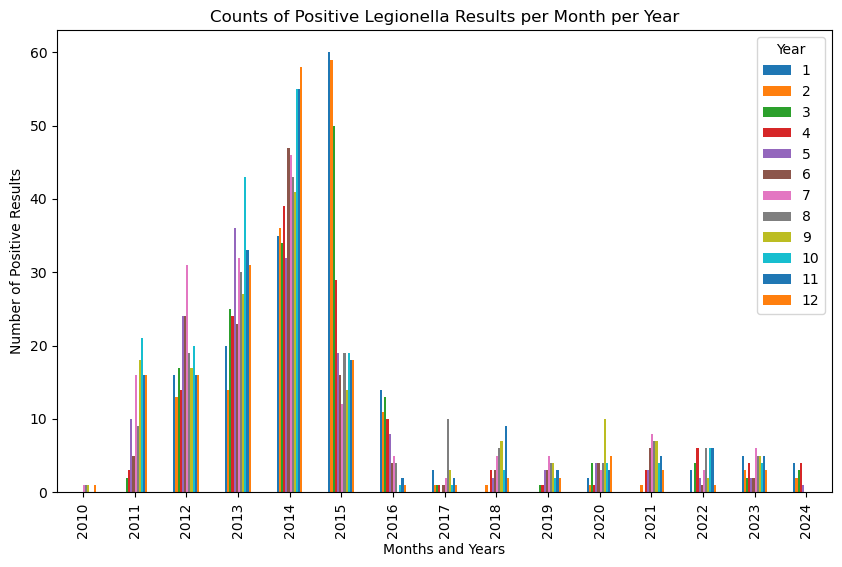

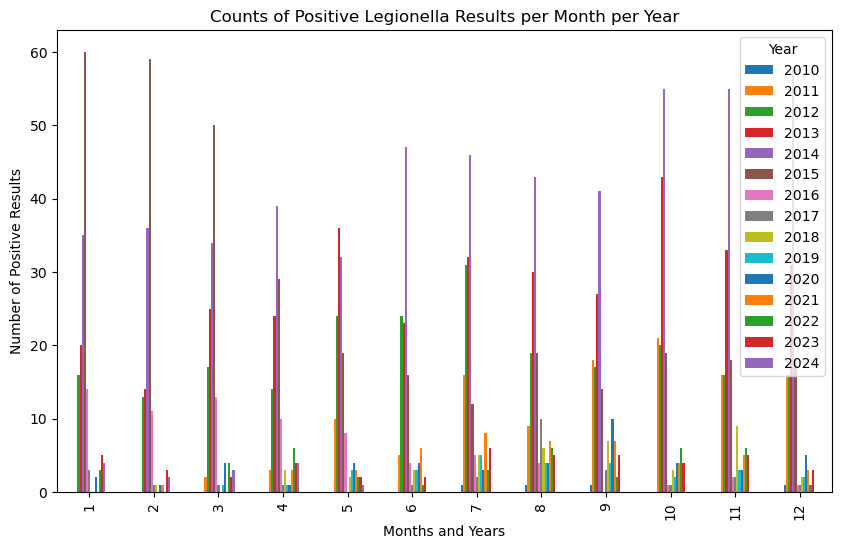

In [42]:
# Quick Eval of Data by Year
pivot_table = grouped_pos_test_y_m.pivot(index='year', columns='month', values='count').fillna(0)
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title('Counts of Positive Legionella Results per Month per Year')
plt.xlabel('Months and Years')
plt.ylabel('Number of Positive Results')
plt.legend(title='Year')
plt.show()

# Quick Eval of data by Month
pivot_table = grouped_pos_test_y_m.pivot(index='month', columns='year', values='count').fillna(0)
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title('Counts of Positive Legionella Results per Month per Year')
plt.xlabel('Months and Years')
plt.ylabel('Number of Positive Results')
plt.legend(title='Year')
plt.show()

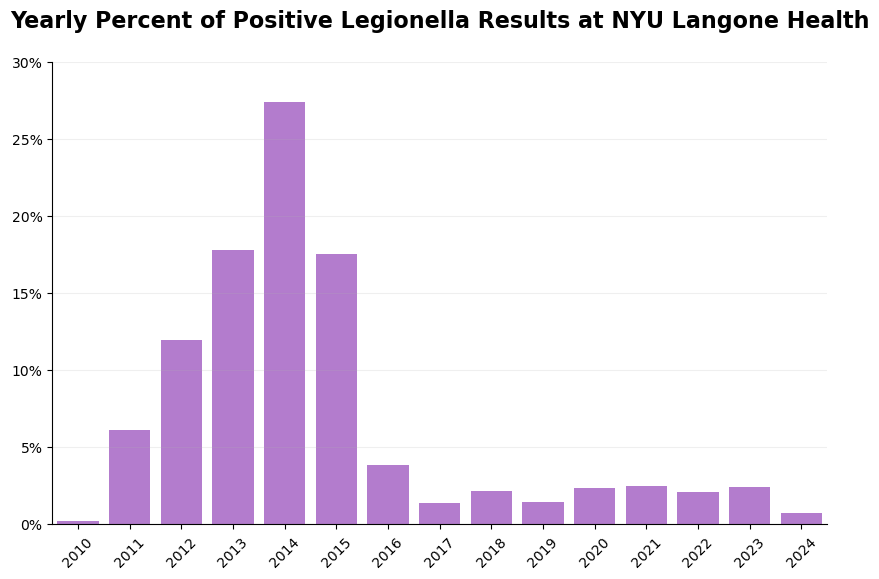

In [43]:
# Plotting yearly percentage of positive legionella tests (Presentation Version)
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='percent_positive', data=df_yearly_percent, color='darkorchid', alpha = 0.7)
plt.title('Yearly Percent of Positive Legionella Results at NYU Langone Health\n', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.xlabel('')
plt.ylim(0, 30)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-', alpha=0.2)
sns.despine()
plt.show()

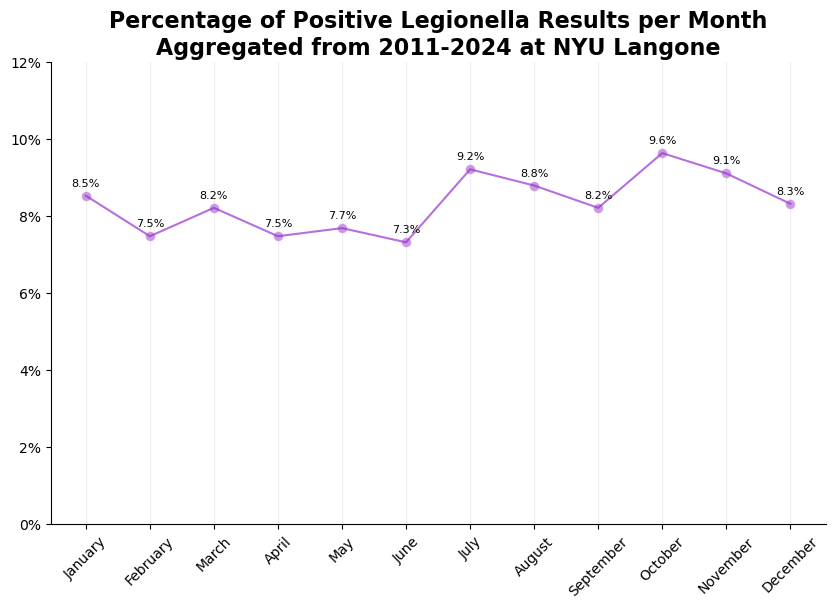

In [44]:
# Plot the average percentage of positive results per month (Presentation Version)
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='percent_positive', data=df_monthly_percent, color='darkorchid', alpha=0.7)
sns.scatterplot(x='month', y='percent_positive', data=df_monthly_percent, color='darkorchid', alpha = 0.5, s=50)
plt.title('Percentage of Positive Legionella Results per Month\nAggregated from 2011-2024 at NYU Langone', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.xlabel('')
plt.ylim(0, 12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.xticks(rotation=45)
for i, row in df_monthly_percent.iterrows():
    plt.text(row['month'], row['percent_positive']+0.2, f"{row['percent_positive']:.1f}%", ha='center', va='bottom', fontsize=8)
plt.grid(axis='x', linestyle='-', alpha=0.2)
sns.despine()
plt.show()

## Question 2: Legionella Positivity vs Cooling Tower Violations


In [45]:
# Import inspection data
df_violations = pd.read_csv('cleaned_data/inspection.csv')

# Filter for only violation code AH8S
df_violations = df_violations[df_violations['violation_code'] == 'AH8S']
total_violations = len(df_violations)

# Group by year and count results
grouped_violation = df_violations.groupby(['Inspection_date']).size().reset_index(name='count')

<Figure size 1000x600 with 0 Axes>

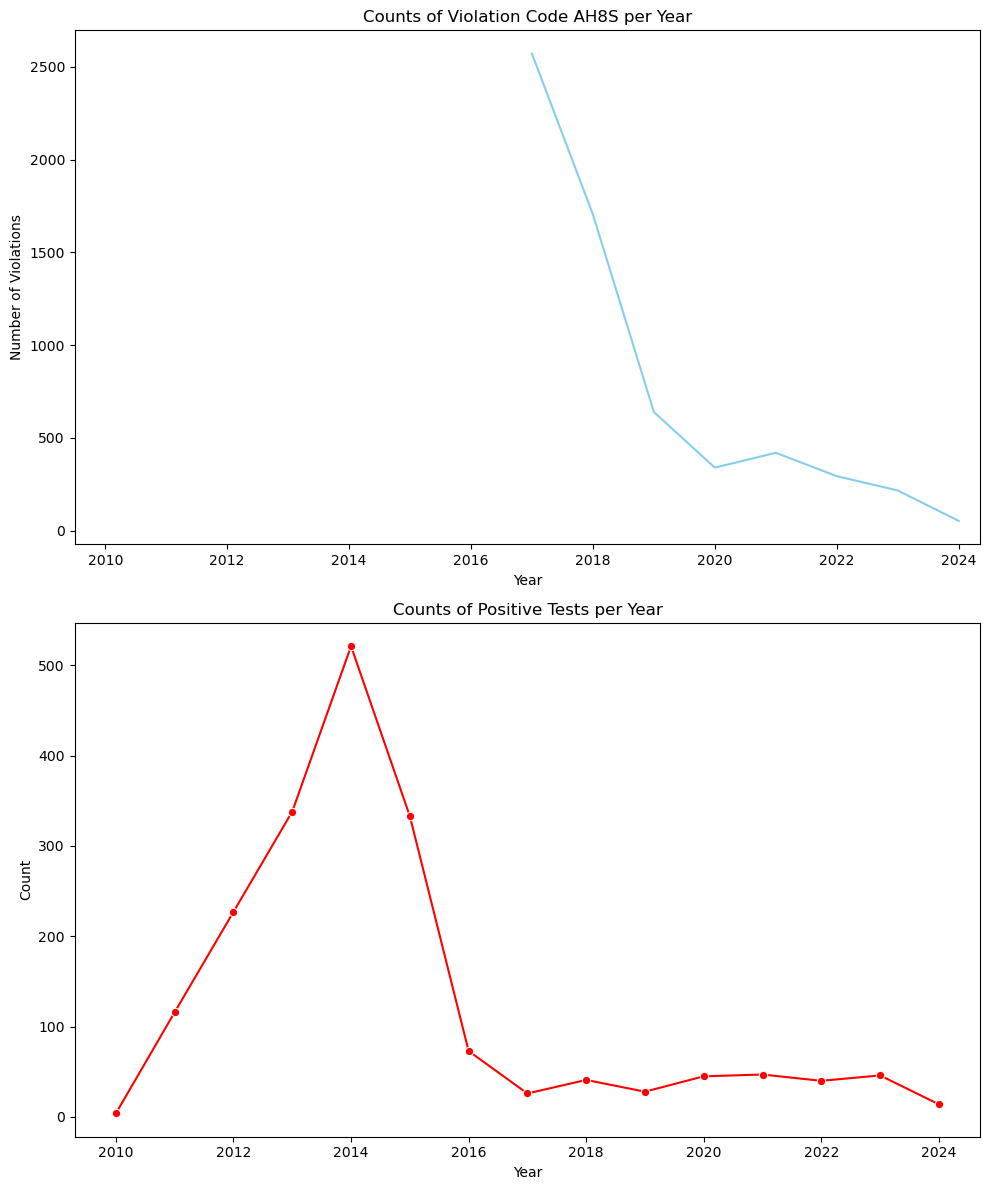

In [46]:
# Quick Eval if Correlation between Violation Code AH8S and Positive Legionella Tests
plt.figure(figsize=(10, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the bar graph for the first dataset
sns.lineplot(data=grouped_violation, x='Inspection_date', y='count', ax=ax1, color='skyblue')
ax1.set_title('Counts of Violation Code AH8S per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Violations')
ax1.set_xlim(left=2009.5) 

# Plot the line graph for the second dataset
sns.lineplot(data=grouped_pos_test_y, x='year', y='count', marker='o', ax=ax2, color='red')
ax2.set_title('Counts of Positive Tests per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [47]:
# Aggregate by year to get percentage of violation  per year and then get percentage of violation per year
# Allow for plotting on same graph with positive tests at NYU Langone

yearly_violation_percent = grouped_violation['count'] / total_violations * 100
df_yearly_violation_percent = pd.DataFrame({'year': grouped_violation['Inspection_date'], 'percent_violation': yearly_violation_percent})
df_violation_case_merged = pd.merge(df_yearly_percent, df_yearly_violation_percent, on='year', how='outer')
df_violation_case_merged

,year,percent_positive,percent_violation
0,2010,0.210637,NaN
1,2011,6.108478,NaN
2,2012,11.953660,NaN
3,2013,17.798841,NaN
4,2014,27.435492,NaN
5,2015,17.535545,NaN
6,2016,3.844128,NaN
7,2017,1.369142,41.248195
8,2018,2.159031,27.338360
9,2019,1.474460,10.251885


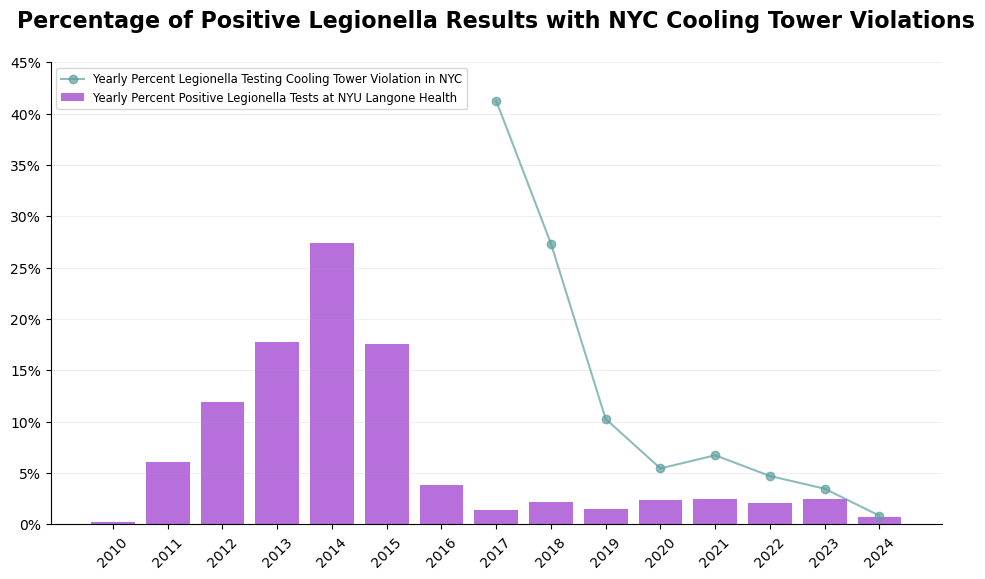

In [48]:
# Plot the percent of legionella code violation per year with the counts of positive legionella tests per year
# Presentation Version
plt.figure(figsize=(11.5, 6))

# Bar plot for percentage of positive results per year
plt.bar(df_violation_case_merged['year'], df_violation_case_merged['percent_positive'], 
        color='darkorchid', alpha=0.7, 
        label='Yearly Percent Positive Legionella Tests at NYU Langone Health')

# Line plot for percentage of violations per inspection date
plt.plot(df_violation_case_merged['year'], df_violation_case_merged['percent_violation'], marker='o', 
         color='cadetblue', alpha=0.7,
         label='Yearly Percent Legionella Testing Cooling Tower Violation in NYC')

plt.title('Percentage of Positive Legionella Results with NYC Cooling Tower Violations\n', fontsize=16, fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.xticks(df_violation_case_merged['year'], rotation=45)

plt.y_ticks = np.arange(0, 45, 5)
plt.ylim(0, 45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.legend(fontsize = 'small', loc='upper left', )

sns.despine()

plt.show()

## Question 3: Percentage of patients given correct antibiotics and antibiotic length for legionella

In [49]:
# Import the testing data
df_ag = pd.read_csv('cleaned_data/urine_antigen.csv')
df_pcr = pd.read_csv('cleaned_data/pcr.csv')
df_abs = pd.read_csv('cleaned_data/abs.csv')

#All encounters with a positive legionella test
df_combined = pd.concat([df_ag, df_pcr, df_abs])
df_combined = df_combined[df_combined['test_result'] == 'positive']

# Make a list of all encounter IDs with a positive legionella test
pos_enc_list = df_combined['enc_id'].unique()
print(f'Number of encounters with a positive legionella test: {len(pos_enc_list)}')

# Filter the DataFrame for encounters that are in the list
df_med = pd.read_csv('cleaned_data/medication.csv')
df_med = df_med[df_med['enc_id'].isin(pos_enc_list)].sort_values('enc_id')
pos_enc_med_list = df_med['enc_id'].unique()

print(f'Number of encounters with a positive legionella test and prescribed antibiotics: {len(pos_enc_med_list)}')

missing_med_encounter = set(pos_enc_list) - set(pos_enc_med_list)
print(f'Number of encounters with a positive legionella test but no medication data: {len(missing_med_encounter)}')

missing_encounter = set(pos_enc_med_list) - set(pos_enc_list)
print(f'Number of encounters with medication data but no positive legionella test: {len(missing_encounter)}')

# Split the 'medication_name' column to only include the first word
df_med['medication_name'] = df_med['medication_name'].str.split(' ').str[0]
df_med['medication_name'] = df_med['medication_name'].str.lower()


# Convert the 'order_start_time' and 'order_end_time' columns to datetime format
df_med['order_start_time'] = pd.to_datetime(df_med['order_start_time'])
df_med['order_end_time'] = pd.to_datetime(df_med['order_end_time'])

df_pt_enc = pd.read_csv('cleaned_data/enc_id_pt_id.csv')
df_med = pd.merge(df_med, df_pt_enc[['enc_id', 'pt_id']], on='enc_id', how='left')

# Dictionary of trade to generic medication names to correct the data
med_trade_generic_dic = {
    'zithromax': 'azithromycin',
    'cipro': 'ciprofloxacin',
    'levaquin': 'levofloxacin',
    'rifabutin': 'rifampin',
    'rifaximin': 'rifampin',
}

# Apply the dictionary to the 'medication_name' column
df_med['medication_name'] = df_med['medication_name'].replace(med_trade_generic_dic)

df_med = df_med[['enc_id', 'pt_id', 'medication_name', 'order_start_time', 'order_end_time']]

# List of medications used to treat legionella
legionella_abx = ['azithromycin',
                  'doxycycline',
                  'levofloxacin',
                  'ciprofloxacin',
                  'moxifloxacin',
                  'norfloxacin',
                  'ofloxacin',
                  'rifampin']

# Filter the DataFrame for only the medications in the list
df_filtered_correct_abx = df_med[df_med['medication_name'].isin(legionella_abx)]
df_filtered_incorrect_abx = df_med[~df_med['medication_name'].isin(legionella_abx)]

# List encounter IDs with correct and incorrect antibiotics
correct_abx_enc = df_filtered_correct_abx['enc_id'].unique()
incorrect_abx_enc = df_filtered_incorrect_abx['enc_id'].unique()

incorrect_meds_encounter = set(incorrect_abx_enc) - set(correct_abx_enc)

# Print the number of encounters with correct and incorrect antibiotics
print(f'Number of encounters with correct antibiotics: {len(correct_abx_enc)}')
print(f'Number of encounters where no correct antibiotics given: {len(incorrect_meds_encounter)}')

Number of encounters with a positive legionella test: 1899
Number of encounters with a positive legionella test and prescribed antibiotics: 1359
Number of encounters with a positive legionella test but no medication data: 540
Number of encounters with medication data but no positive legionella test: 0
Number of encounters with correct antibiotics: 1079
Number of encounters where no correct antibiotics given: 280


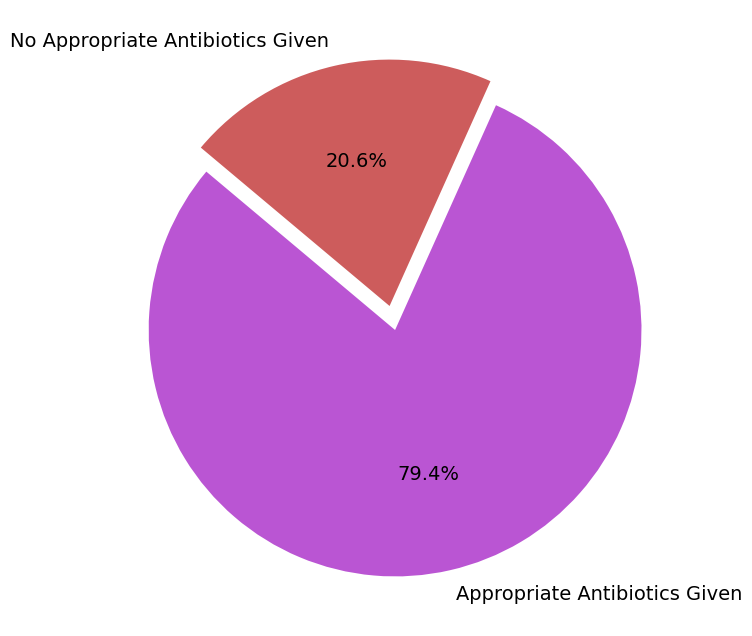

In [50]:
labels = ['Appropriate Antibiotics Given', 'No Appropriate Antibiotics Given']
sizes = [len(correct_abx_enc), len(incorrect_meds_encounter)]  # Values for the two categories

# Plot the pie chart
plt.figure(figsize=(8, 8))
explode = [0.05, 0.05] 
plt.pie(sizes, 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=140,
        colors=['mediumorchid', 'indianred'],
        explode=explode,
        textprops={'fontsize': 14})
plt.show()

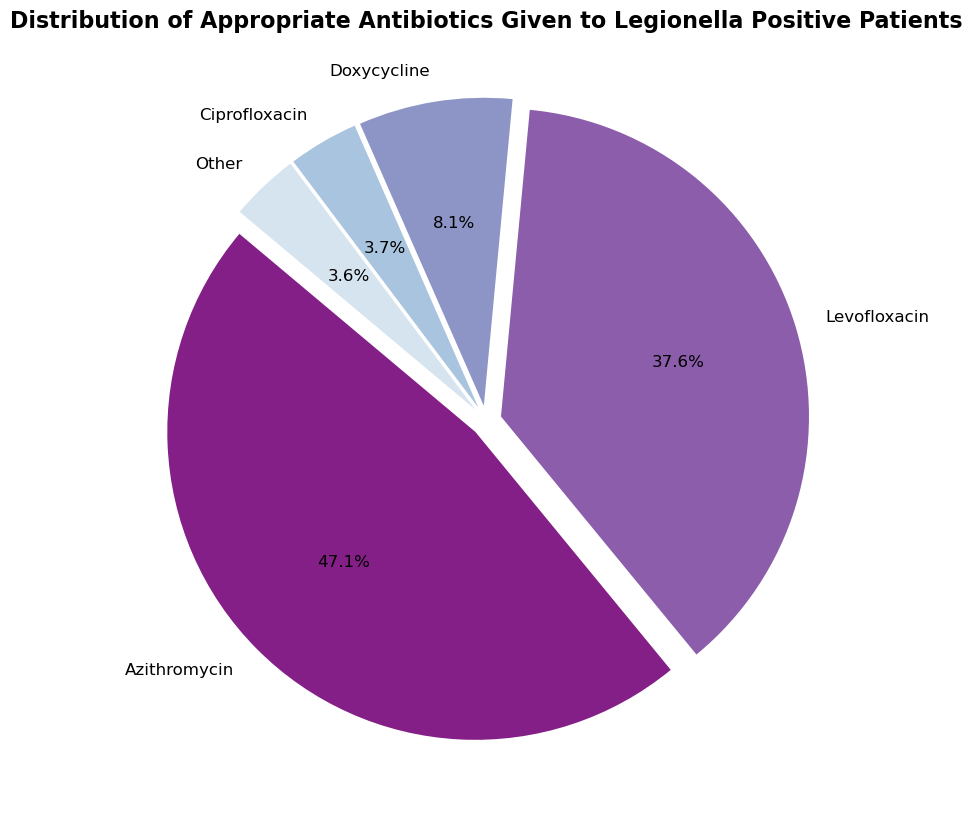

In [51]:
# Pie chart of appropriate antibiotics given to legionella positive patients

df_pos_correct_abx = df_filtered_correct_abx[df_filtered_correct_abx['enc_id'].isin(correct_abx_enc)]
medication_counts = df_pos_correct_abx['medication_name'].value_counts()

# Define a threshold for grouping into "Other"
threshold = 100

# Group smaller categories into "Other"
medication_counts_other = medication_counts[medication_counts <= threshold]
medication_counts_main = medication_counts[medication_counts > threshold]
medication_counts_main['Other'] = medication_counts_other.sum()

labels = medication_counts_main.index.str.title()
colors = sns.color_palette('BuPu', len(medication_counts_main))[::-1]

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(medication_counts_main, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        textprops={'fontsize': 12},
        explode=[0.05] * len(medication_counts_main),
        colors=colors)
plt.title('Distribution of Appropriate Antibiotics Given to Legionella Positive Patients', fontsize=16, fontweight='bold')
plt.show()

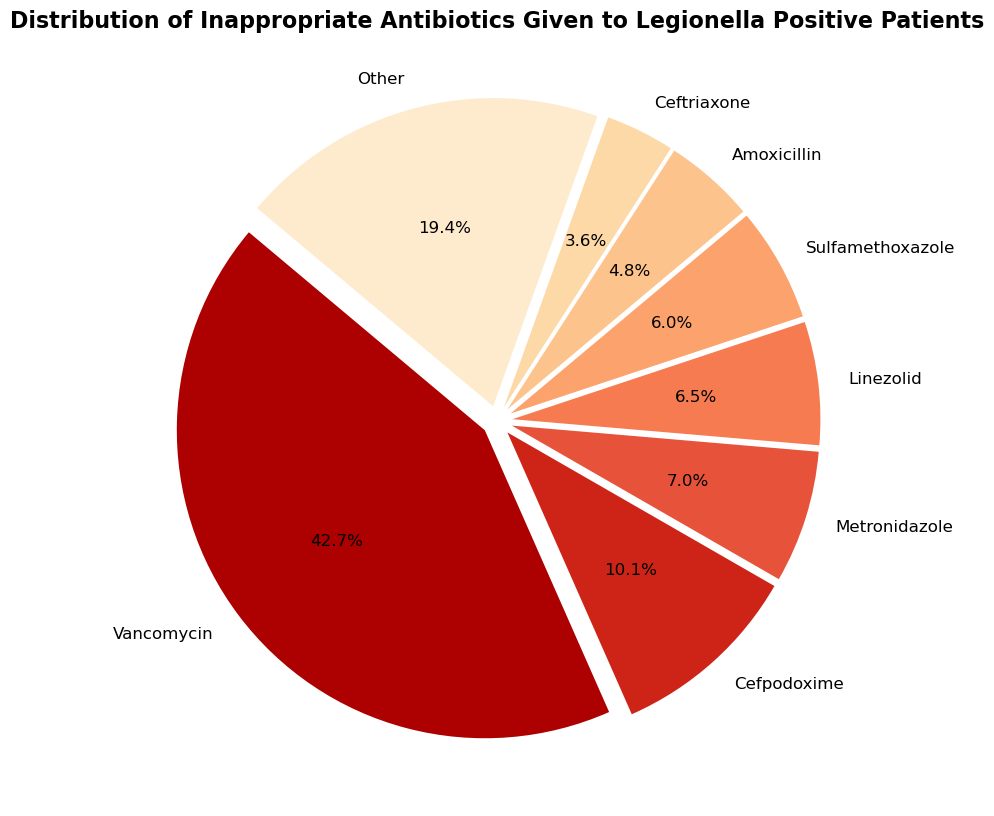

In [52]:
# Pie Chart of inappropriate antibiotics given to legionella positive patients

df_pos_incorrect_abx = df_filtered_incorrect_abx[df_filtered_incorrect_abx['enc_id'].isin(incorrect_abx_enc)]
medication_counts = df_pos_incorrect_abx['medication_name'].value_counts()

# Define a threshold for grouping into "Other"
threshold = 100

# Group smaller categories into "Other"
medication_counts_other = medication_counts[medication_counts <= threshold]
medication_counts_main = medication_counts[medication_counts > threshold]
medication_counts_main['Other'] = medication_counts_other.sum()

labels = medication_counts_main.index.str.title()
colors = sns.color_palette('OrRd', len(medication_counts_main))[::-1]

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(medication_counts_main, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        textprops={'fontsize': 12},
        explode=[0.05] * len(medication_counts_main),
        colors=colors)
plt.title('Distribution of Inappropriate Antibiotics Given to Legionella Positive Patients', fontsize=16, fontweight='bold')
plt.show()

In [53]:
df_pos_correct_abx = df_filtered_correct_abx[df_filtered_correct_abx['enc_id'].isin(correct_abx_enc)]

df_med_agg = df_pos_correct_abx.groupby(['pt_id', 'medication_name']).agg(
    earliest_order_start_time=('order_start_time', 'min'),
    latest_order_end_time=('order_end_time', 'max')
).reset_index()

df_med_agg['time_given'] = (df_med_agg['latest_order_end_time'] - df_med_agg['earliest_order_start_time']).dt.days
df_med_agg['time_given'] = df_med_agg[df_med_agg['time_given'] > 0]['time_given']
print('Duration mean:',df_med_agg['time_given'].mean())
print('Duration median:',df_med_agg['time_given'].median())

Duration mean: 43.67220683287165
Duration median: 7.0


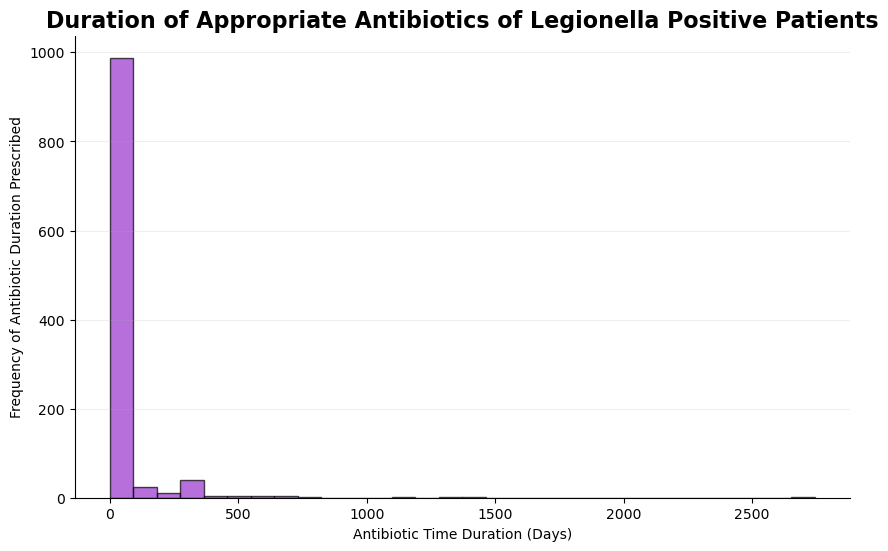

In [54]:
# Create a histogram of lenght antibiotics given
plt.figure(figsize=(10, 6))

plt.hist(df_med_agg['time_given'], bins=30, edgecolor='black', color='darkorchid', alpha=0.7)
plt.title('Duration of Appropriate Antibiotics of Legionella Positive Patients', fontsize=16, fontweight='bold')
plt.xlabel('Antibiotic Time Duration (Days)')
plt.ylabel('Frequency of Antibiotic Duration Prescribed')
plt.grid(axis='y', linestyle='-', alpha=0.2)
sns.despine()
plt.show()

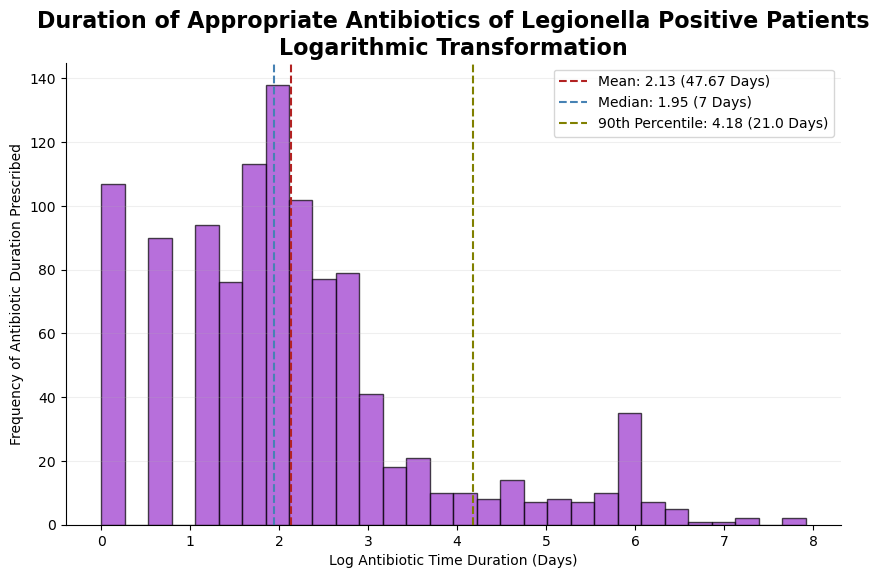

In [ ]:
# Apply a logarithmic transformation to the non-zero 'time_given' column
log_time_given = np.log(df_med_agg['time_given'])
log_time_given = log_time_given.dropna()

# Calculate the percentiles
q90 = np.percentile(log_time_given, 90)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(log_time_given, bins=30, edgecolor='black', color='darkorchid', alpha=0.7)
plt.title('Duration of Appropriate Antibiotics of Legionella Positive Patients\nLogarithmic Transformation', fontsize=16, fontweight='bold')
plt.xlabel('Log Antibiotic Time Duration (Days)')
plt.ylabel('Frequency of Antibiotic Duration Prescribed')
plt.grid(axis='y', linestyle='-', alpha=0.2)

# Add important lines
plt.axvline(log_time_given.mean(), color='firebrick', linestyle='--', label=f'Mean: {log_time_given.mean():.2f} (47.67 Days)')
plt.axvline(log_time_given.median(), color='steelblue', linestyle='--', label=f'Median: {log_time_given.median():.2f} (7 Days)')
plt.axvline(q90, color='olive', linestyle='--', label=f'90th Percentile: {q90:.2f} (21.0 Days)')
plt.legend()
sns.despine()

plt.show()

## Question 4: Correlation between positive and negative results between urine antigen, PCR, and antibodies

In [56]:
# Import the testing data
df_ag = pd.read_csv('cleaned_data/urine_antigen.csv')
df_pcr = pd.read_csv('cleaned_data/pcr.csv')
df_abs = pd.read_csv('cleaned_data/abs.csv')

# Filter the relevant columns
df_ag_filtered = df_ag[['enc_id', 'test_result']].rename(columns={'test_result': 'test_result_ag'})
df_pcr_filtered = df_pcr[['enc_id', 'test_result']].rename(columns={'test_result': 'test_result_pcr'})
df_abs_filtered = df_abs[['enc_id', 'test_result']].rename(columns={'test_result': 'test_result_abs'})

# Combine the DataFrames using inner join
df_merged_ag_pcr = df_ag_filtered.merge(df_pcr_filtered, on='enc_id', how='inner')
df_merged_ag_abs = df_ag_filtered.merge(df_abs_filtered, on='enc_id', how='inner')

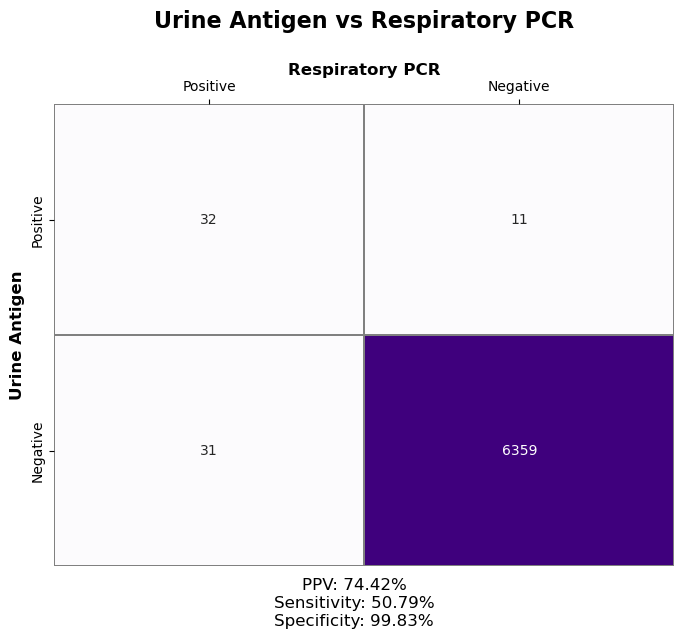

In [57]:
# Create confusion matrix for AG vs PCR
confusion_matrix_ag_pcr = pd.crosstab(df_merged_ag_pcr['test_result_ag'], df_merged_ag_pcr['test_result_pcr'], rownames=['PCR'], colnames=['Urine Antigen'])

# Reorder the index and columns to switch 'negative' and 'positive' positions
order = ['positive', 'negative']
confusion_matrix_ag_pcr = confusion_matrix_ag_pcr.reindex(index=order, columns=order)

# Capitalize the labels
confusion_matrix_ag_pcr.index = confusion_matrix_ag_pcr.index.str.title()
confusion_matrix_ag_pcr.columns = confusion_matrix_ag_pcr.columns.str.title()

# Calculate sensitivity and specificity
TP = confusion_matrix_ag_pcr.loc['Positive', 'Positive']
TN = confusion_matrix_ag_pcr.loc['Negative', 'Negative']
FP = confusion_matrix_ag_pcr.loc['Positive', 'Negative']
FN = confusion_matrix_ag_pcr.loc['Negative', 'Positive']

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix_ag_pcr, annot=True, fmt='d', cmap='Purples', cbar=False, linewidths=0.2, linecolor='grey')
ax.set_title('Urine Antigen vs Respiratory PCR\n', fontsize=16, fontweight='bold')
ax.set_ylabel('Urine Antigen', fontsize=12, fontweight='bold')
ax.set_xlabel('Respiratory PCR', fontsize=12, fontweight='bold')

# Move x-axis label to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Display sensitivity and specificity
plt.figtext(0.5, 0.04, f'Sensitivity: {sensitivity * 100:.2f}%', ha='center', fontsize=12)
plt.figtext(0.5, 0.01, f'Specificity: {specificity * 100:.2f}%', ha='center', fontsize=12)
plt.figtext(0.5, 0.07, f'PPV: {ppv * 100:.2f}%', ha='center', fontsize=12)

plt.show()

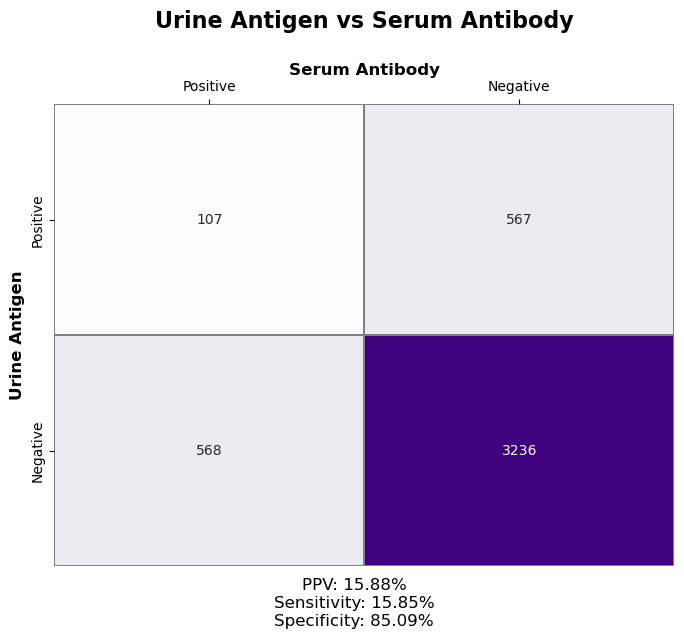

In [58]:
# Create confusion matrix for AG vs Abs
confusion_matrix_ag_pcr = pd.crosstab(df_merged_ag_abs['test_result_ag'], df_merged_ag_abs['test_result_abs'], rownames=['PCR'], colnames=['Urine Antigen'])

# Reorder the index and columns to switch 'negative' and 'positive' positions
order = ['positive', 'negative']
confusion_matrix_ag_pcr = confusion_matrix_ag_pcr.reindex(index=order, columns=order)

# Capitalize the labels
confusion_matrix_ag_pcr.index = confusion_matrix_ag_pcr.index.str.title()
confusion_matrix_ag_pcr.columns = confusion_matrix_ag_pcr.columns.str.title()

# Calculate sensitivity and specificity
TP = confusion_matrix_ag_pcr.loc['Positive', 'Positive']
TN = confusion_matrix_ag_pcr.loc['Negative', 'Negative']
FP = confusion_matrix_ag_pcr.loc['Positive', 'Negative']
FN = confusion_matrix_ag_pcr.loc['Negative', 'Positive']

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix_ag_pcr, annot=True, fmt='d', cmap='Purples', cbar=False, linewidths=0.2, linecolor='grey')
ax.set_title('Urine Antigen vs Serum Antibody\n', fontsize=16, fontweight='bold')
ax.set_ylabel('Urine Antigen', fontsize=12, fontweight='bold')
ax.set_xlabel('Serum Antibody', fontsize=12, fontweight='bold')

# Move x-axis label to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Display sensitivity and specificity
plt.figtext(0.5, 0.04, f'Sensitivity: {sensitivity * 100:.2f}%', ha='center', fontsize=12)
plt.figtext(0.5, 0.01, f'Specificity: {specificity * 100:.2f}%', ha='center', fontsize=12)
plt.figtext(0.5, 0.07, f'PPV: {ppv * 100:.2f}%', ha='center', fontsize=12)

plt.show()

## Question 5: Characteristics among  patients with legionella compared to those without legionella when the diagnosis  is pneumonia.


In [59]:
# File paths
file_paths = {
    "abs": "cleaned_data/abs.csv",
    "diagnosis": "cleaned_data/diagnosis.csv",
    "enc_id_pt_id": "cleaned_data/enc_id_pt_id.csv",
    "encounter": "cleaned_data/encounter.csv",
    "inspection": "cleaned_data/inspection.csv",
    "medication": "cleaned_data/medication.csv",
    "patient": "cleaned_data/patient.csv",
    "pcr": "cleaned_data/pcr.csv",
    "urine_antigen": "cleaned_data/urine_antigen.csv",
}

# Load datasets
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Preview first few rows of each dataset
for name, df in dataframes.items():
    print(f"Dataset: {name}")
    print(df.head(), "\n")


Dataset: abs
                enc_id test_name test_result result_time
0  4788652119311449749  antibody    negative  2014-02-09
1   473527142110099312  antibody    negative  2014-02-27
2  2916569464947500530  antibody    negative  2012-06-26
3  6645247072530359702  antibody    negative  2012-07-27
4  2293010662835670076  antibody    negative  2013-10-17 

Dataset: diagnosis
                enc_id                dx_name
0  1372891072567729500                 sepsis
1  1372891072567729500                 sepsis
2  5365471817567830831  pulmonary_abnormality
3  5365471817567830831  pulmonary_abnormality
4  5365471817567830831  pulmonary_abnormality 

Dataset: enc_id_pt_id
                enc_id                pt_id
0  3975049077239673395 -2809235875882990763
1 -5061831035098387866  5854567137542095248
2  6552655377892982779 -6367218150678696176
3 -3027420987132274233 -3367994639189120993
4 -7079776670532774587 -5049807079949078850 

Dataset: encounter
                enc_id  enc_year    enc

In [60]:
for name, df in dataframes.items():
    print(f"Dataset: {name}")
    print(df.info(), "\n")

Dataset: abs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   enc_id       4920 non-null   int64 
 1   test_name    4920 non-null   object
 2   test_result  4920 non-null   object
 3   result_time  4920 non-null   object
dtypes: int64(1), object(3)
memory usage: 153.9+ KB
None 

Dataset: diagnosis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499222 entries, 0 to 499221
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   enc_id   499222 non-null  int64 
 1   dx_name  499222 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.6+ MB
None 

Dataset: enc_id_pt_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55369 entries, 0 to 55368
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   enc_id  55369 non-null  int64
 1 

In [61]:
# Connect to SQLite database
conn = sqlite3.connect('cleaned_data/healthcare_data.db')
cursor = conn.cursor()

# Step 4A: Create tables
# Patient table
cursor.execute("""
CREATE TABLE IF NOT EXISTS patient (
    pt_id INTEGER PRIMARY KEY,
    sex TEXT,
    age INTEGER,
    age_bucket TEXT
);
""")

# Encounter table
cursor.execute("""
CREATE TABLE IF NOT EXISTS encounter (
    enc_id INTEGER PRIMARY KEY,
    enc_year INTEGER,
    enc_type TEXT
);
""")

# Encounter to Patient ID mapping table
cursor.execute("""
CREATE TABLE IF NOT EXISTS enc_id_pt_id (
    enc_id INTEGER,
    pt_id INTEGER,
    FOREIGN KEY (enc_id) REFERENCES encounter(enc_id),
    FOREIGN KEY (pt_id) REFERENCES patient(pt_id)
);
""")

# Diagnosis table
cursor.execute("""
CREATE TABLE IF NOT EXISTS diagnosis (
    enc_id INTEGER,
    dx_name TEXT,
    FOREIGN KEY (enc_id) REFERENCES encounter(enc_id)
);
""")

# Lab Results table (combining abs, pcr, and urine_antigen datasets)
cursor.execute("""
CREATE TABLE IF NOT EXISTS lab_results (
    enc_id INTEGER,
    test_name TEXT,
    test_result TEXT,
    result_time TEXT,
    FOREIGN KEY (enc_id) REFERENCES encounter(enc_id)
);
""")

# Medication table
cursor.execute("""
CREATE TABLE IF NOT EXISTS medication (
    enc_id INTEGER,
    medication_name TEXT,
    order_start_time TEXT,
    order_end_time TEXT,
    FOREIGN KEY (enc_id) REFERENCES encounter(enc_id)
);
""")

conn.commit()

# Step 4B: Populate tables
# Insert data into patient table
dataframes["patient"].to_sql("patient", conn, if_exists="replace", index=False)

# Insert data into encounter table
dataframes["encounter"].to_sql("encounter", conn, if_exists="replace", index=False)

# Insert data into encounter-to-patient mapping table
dataframes["enc_id_pt_id"].to_sql("enc_id_pt_id", conn, if_exists="replace", index=False)

# Insert data into diagnosis table
dataframes["diagnosis"].to_sql("diagnosis", conn, if_exists="replace", index=False)

# Combine lab data and insert into lab_results table
lab_results = pd.concat([dataframes["abs"], dataframes["pcr"], dataframes["urine_antigen"]])
lab_results.to_sql("lab_results", conn, if_exists="replace", index=False)

# Insert data into medication table
dataframes["medication"].to_sql("medication", conn, if_exists="replace", index=False)

print("Tables created and data successfully inserted into the database.")

# Step 4C: Verify data in tables
tables = ["patient", "encounter", "enc_id_pt_id", "diagnosis", "lab_results", "medication"]
for table in tables:
    print(f"\nVerifying table: {table}")
    result = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5;", conn)
    print(result)


Tables created and data successfully inserted into the database.

Verifying table: patient
                 pt_id     sex  age age_bucket
0  3013939574033803906    Male   84      80-89
1 -4955299412922112414  Female   88      80-89
2 -4690851033038895663    Male   18      10-19
3 -7660776755063619649  Female    7        0-9
4  2390066754025880690  Female   59      50-59

Verifying table: encounter
                enc_id  enc_year    enc_type
0 -2351246031288901868      2023   inpatient
1  7737624844017017966      2023   inpatient
2  8126526588940491562      2024   inpatient
3 -3569220862922256511      2015  outpatient
4   963918296760474661      2015   inpatient

Verifying table: enc_id_pt_id
                enc_id                pt_id
0  3975049077239673395 -2809235875882990763
1 -5061831035098387866  5854567137542095248
2  6552655377892982779 -6367218150678696176
3 -3027420987132274233 -3367994639189120993
4 -7079776670532774587 -5049807079949078850

Verifying table: diagnosis
      

In [62]:
# List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('patient',), ('encounter',), ('enc_id_pt_id',), ('diagnosis',), ('lab_results',), ('medication',)]


In [63]:
# Query to find Legionella cases in pneumonia
query_legionella = """
    SELECT
        ep.pt_id,
        e.enc_id,
        e.enc_year,
        e.enc_type,
        d.dx_name
    FROM
        diagnosis d
    JOIN
        enc_id_pt_id ep ON d.enc_id = ep.enc_id
    JOIN
        encounter e ON ep.enc_id = e.enc_id
    WHERE
        d.dx_name LIKE '%Legionella%' AND e.enc_type = 'pneumonia';
"""
legionella_cases = pd.read_sql_query(query_legionella, conn)
print("Legionella Cases in Pneumonia:")
print(legionella_cases.head())


Legionella Cases in Pneumonia:
Empty DataFrame
Columns: [pt_id, enc_id, enc_year, enc_type, dx_name]
Index: []


In [64]:
# Check unique values in diagnosis.dx_name
query_dx_name = "SELECT DISTINCT dx_name FROM diagnosis LIMIT 20;"
dx_name_values = pd.read_sql_query(query_dx_name, conn)
print("Distinct dx_name values:")
print(dx_name_values)


Distinct dx_name values:
                    dx_name
0                    sepsis
1     pulmonary_abnormality
2       cardiac_abnormality
3                     other
4         renal_abnormality
5            gi_abnormality
6             mental_health
7    neurologic_abnormality
8          end_of_life_care
9     endocrine_abnormality
10  hematologic_abnormality
11     urologic_abnormality
12  rheumatolic_abnormality


In [65]:
# Check unique values in encounter.enc_type
query_enc_type = "SELECT DISTINCT enc_type FROM encounter LIMIT 20;"
enc_type_values = pd.read_sql_query(query_enc_type, conn)
print("Distinct enc_type values:")
print(enc_type_values)

Distinct enc_type values:
     enc_type
0   inpatient
1  outpatient


In [66]:
query_pulmonary_cases = """
    SELECT
        ep.pt_id,
        e.enc_id,
        e.enc_year,
        e.enc_type,
        d.dx_name
    FROM
        diagnosis d
    JOIN
        enc_id_pt_id ep ON d.enc_id = ep.enc_id
    JOIN
        encounter e ON ep.enc_id = e.enc_id
    WHERE
        d.dx_name = 'pulmonary_abnormality';
"""
pulmonary_cases = pd.read_sql_query(query_pulmonary_cases, conn)
print("Pulmonary Abnormality Cases:")
print(pulmonary_cases.head())

Pulmonary Abnormality Cases:
                 pt_id               enc_id  enc_year   enc_type  \
0  5206962217824183445  5365471817567830831      2022  inpatient   
1  5206962217824183445  5365471817567830831      2022  inpatient   
2  5206962217824183445  5365471817567830831      2022  inpatient   
3 -4385033305035558903  7572677654996029119      2023  inpatient   
4 -7236550678582388900  3061976122045512101      2023  inpatient   

                 dx_name  
0  pulmonary_abnormality  
1  pulmonary_abnormality  
2  pulmonary_abnormality  
3  pulmonary_abnormality  
4  pulmonary_abnormality  


In [67]:
# Distribution of inpatient and outpatient encounters
pulmonary_case_distribution = pulmonary_cases["enc_type"].value_counts()
print("Distribution of encounter types for pulmonary abnormality cases:")
print(pulmonary_case_distribution)

Distribution of encounter types for pulmonary abnormality cases:
enc_type
inpatient     81115
outpatient      299
Name: count, dtype: int64


In [68]:
# Merge pulmonary abnormality cases with patient data
pulmonary_patients = pd.merge(pulmonary_cases, dataframes["patient"], on="pt_id", how="left")
print("Pulmonary Abnormality Patient Demographics:")
print(pulmonary_patients.head())

# Analyze demographics
pulmonary_demographics = pulmonary_patients.groupby("sex")["age"].describe()
print("Pulmonary Abnormality Demographics by Gender:")
print(pulmonary_demographics)

Pulmonary Abnormality Patient Demographics:
                 pt_id               enc_id  enc_year   enc_type  \
0  5206962217824183445  5365471817567830831      2022  inpatient   
1  5206962217824183445  5365471817567830831      2022  inpatient   
2  5206962217824183445  5365471817567830831      2022  inpatient   
3 -4385033305035558903  7572677654996029119      2023  inpatient   
4 -7236550678582388900  3061976122045512101      2023  inpatient   

                 dx_name     sex   age age_bucket  
0  pulmonary_abnormality  Female  75.0      70-79  
1  pulmonary_abnormality  Female  75.0      70-79  
2  pulmonary_abnormality  Female  75.0      70-79  
3  pulmonary_abnormality  Female  82.0      80-89  
4  pulmonary_abnormality    Male  56.0      50-59  
Pulmonary Abnormality Demographics by Gender:
          count       mean        std  min   25%   50%   75%   max
sex                                                               
Female  37524.0  72.593513  17.834020  0.0  64.0  77.0 

In [69]:
# Query for Legionella-related lab tests
query_legionella_lab = """
    SELECT
        l.enc_id,
        l.test_name,
        l.test_result,
        l.result_time
    FROM
        lab_results l
    WHERE
        l.test_name LIKE '%antigen%' OR l.test_name LIKE '%antibody%';
"""
legionella_lab_results = pd.read_sql_query(query_legionella_lab, conn)
print("Legionella Lab Results:")
print(legionella_lab_results.head())

Legionella Lab Results:
                enc_id test_name test_result result_time
0  4788652119311449749  antibody    negative  2014-02-09
1   473527142110099312  antibody    negative  2014-02-27
2  2916569464947500530  antibody    negative  2012-06-26
3  6645247072530359702  antibody    negative  2012-07-27
4  2293010662835670076  antibody    negative  2013-10-17


In [70]:
# Merge pulmonary cases with Legionella lab results
pulmonary_with_legionella = pd.merge(
    pulmonary_patients, legionella_lab_results, on="enc_id", how="left"
)
print("Pulmonary Cases with Legionella Lab Results:")
print(pulmonary_with_legionella.head())

Pulmonary Cases with Legionella Lab Results:
                 pt_id               enc_id  enc_year   enc_type  \
0  5206962217824183445  5365471817567830831      2022  inpatient   
1  5206962217824183445  5365471817567830831      2022  inpatient   
2  5206962217824183445  5365471817567830831      2022  inpatient   
3 -4385033305035558903  7572677654996029119      2023  inpatient   
4 -7236550678582388900  3061976122045512101      2023  inpatient   

                 dx_name     sex   age age_bucket test_name test_result  \
0  pulmonary_abnormality  Female  75.0      70-79       NaN         NaN   
1  pulmonary_abnormality  Female  75.0      70-79       NaN         NaN   
2  pulmonary_abnormality  Female  75.0      70-79       NaN         NaN   
3  pulmonary_abnormality  Female  82.0      80-89       NaN         NaN   
4  pulmonary_abnormality    Male  56.0      50-59       NaN         NaN   

  result_time  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

In [71]:
# Separate Legionella-positive and negative cases
legionella_positive = pulmonary_with_legionella[pulmonary_with_legionella["test_result"] == "positive"]
legionella_negative = pulmonary_with_legionella[pulmonary_with_legionella["test_result"] == "negative"]

print("Legionella-Positive Cases:")
print(legionella_positive.head())

print("\nLegionella-Negative Cases:")
print(legionella_negative.head())

Legionella-Positive Cases:
                   pt_id               enc_id  enc_year   enc_type  \
96  -1845599925590428861 -4841630154721101656      2015  inpatient   
97  -1845599925590428861 -4841630154721101656      2015  inpatient   
211 -1418458881343352959 -5850840596145041689      2014  inpatient   
250  8931231292633431013  1228405154926704010      2014  inpatient   
323  6795710020187288425 -2241542316197196131      2014  inpatient   

                   dx_name     sex   age age_bucket test_name test_result  \
96   pulmonary_abnormality  Female  90.0        90+  antibody    positive   
97   pulmonary_abnormality  Female  90.0        90+  antibody    positive   
211  pulmonary_abnormality  Female  65.0      60-69  antibody    positive   
250  pulmonary_abnormality    Male  80.0      80-89  antibody    positive   
323  pulmonary_abnormality    Male  90.0        90+  antibody    positive   

    result_time  
96   2015-12-12  
97   2015-12-12  
211  2014-10-31  
250  2014-10-22  

In [72]:
# Compare age statistics
print("Legionella-Positive Cases Age Statistics:")
print(legionella_positive["age"].describe())

print("\nLegionella-Negative Cases Age Statistics:")
print(legionella_negative["age"].describe())

Legionella-Positive Cases Age Statistics:
count    1300.000000
mean       77.123077
std        15.071712
min        26.000000
25%        70.000000
50%        83.000000
75%        90.000000
max        90.000000
Name: age, dtype: float64

Legionella-Negative Cases Age Statistics:
count    6264.000000
mean       78.148787
std        13.980583
min        27.000000
25%        71.000000
50%        82.000000
75%        90.000000
max        90.000000
Name: age, dtype: float64


In [73]:
# Compare gender distribution
legionella_positive_gender = legionella_positive["sex"].value_counts(normalize=True) * 100
legionella_negative_gender = legionella_negative["sex"].value_counts(normalize=True) * 100

print("Legionella-Positive Gender Distribution (%):")
print(legionella_positive_gender)

print("\nLegionella-Negative Gender Distribution (%):")
print(legionella_negative_gender)

Legionella-Positive Gender Distribution (%):
sex
Male      56.384615
Female    43.615385
Name: proportion, dtype: float64

Legionella-Negative Gender Distribution (%):
sex
Male      50.478927
Female    49.521073
Name: proportion, dtype: float64


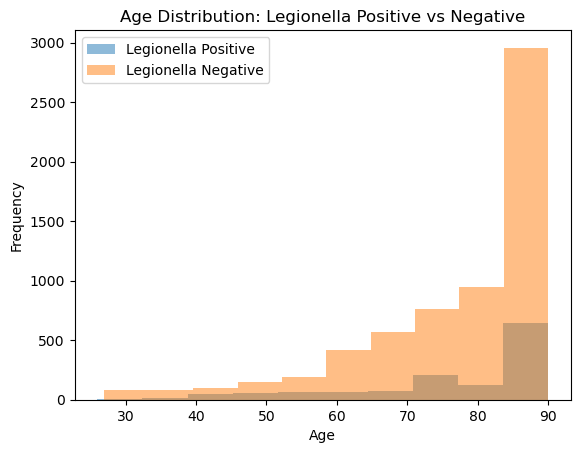

In [74]:
# Plot age distribution
plt.hist(legionella_positive["age"], bins=10, alpha=0.5, label="Legionella Positive")
plt.hist(legionella_negative["age"], bins=10, alpha=0.5, label="Legionella Negative")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.title("Age Distribution: Legionella Positive vs Negative")
plt.show()

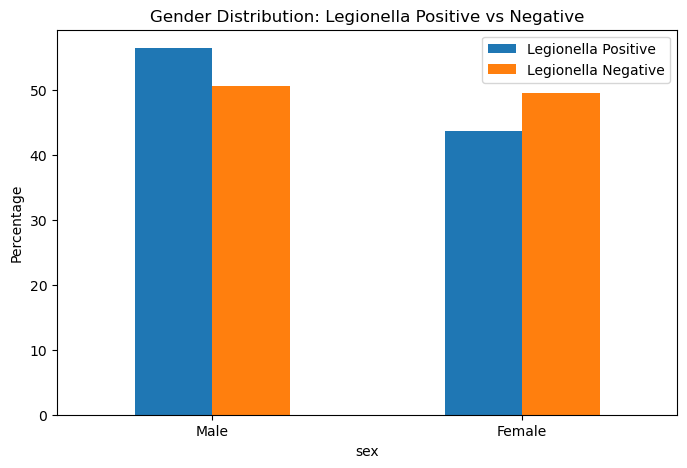

In [75]:
# Bar plot for gender distribution
gender_data = pd.DataFrame({
    "Legionella Positive": legionella_positive_gender,
    "Legionella Negative": legionella_negative_gender
})
gender_data.plot(kind="bar", figsize=(8, 5))
plt.title("Gender Distribution: Legionella Positive vs Negative")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()


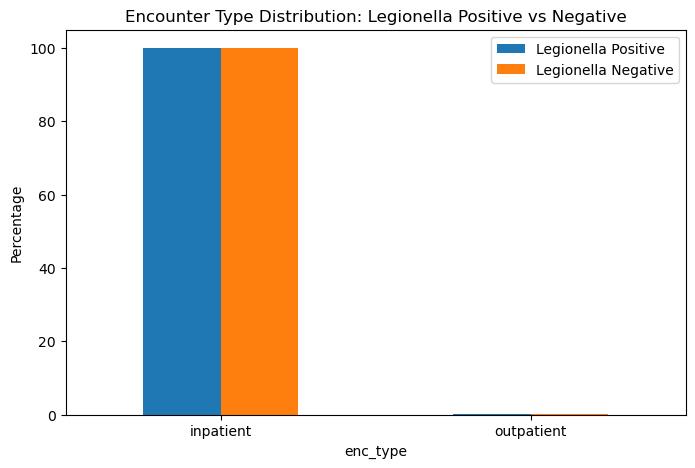

In [76]:
# Encounter type distribution
positive_enc_type_dist = legionella_positive["enc_type"].value_counts(normalize=True) * 100
negative_enc_type_dist = legionella_negative["enc_type"].value_counts(normalize=True) * 100

# Bar plot for encounter type distribution
encounter_data = pd.DataFrame({
    "Legionella Positive": positive_enc_type_dist,
    "Legionella Negative": negative_enc_type_dist
})
encounter_data.plot(kind="bar", figsize=(8, 5))
plt.title("Encounter Type Distribution: Legionella Positive vs Negative")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()


In [77]:
# Check intersection of enc_id between pulmonary cases and lab results
common_enc_ids = set(pulmonary_patients["enc_id"]).intersection(set(legionella_lab_results["enc_id"]))
print(f"Number of common enc_id between pulmonary cases and lab results: {len(common_enc_ids)}")

Number of common enc_id between pulmonary cases and lab results: 2564


In [78]:
# Filter pulmonary cases with corresponding lab results
pulmonary_with_lab = pulmonary_patients[pulmonary_patients["enc_id"].isin(legionella_lab_results["enc_id"])]
print(f"Number of pulmonary cases with lab results: {pulmonary_with_lab.shape[0]}")

Number of pulmonary cases with lab results: 7109


In [79]:
# Check missing data in test_name and test_result columns
missing_lab_results = pulmonary_with_legionella[["test_name", "test_result"]].isnull().sum()
print("Missing lab result data:")
print(missing_lab_results)

Missing lab result data:
test_name      74305
test_result    74305
dtype: int64


In [80]:
# Age statistics for all pulmonary abnormality cases
age_all_pulmonary = pulmonary_patients["age"].describe()
print("Age distribution for all pulmonary abnormality cases:")
print(age_all_pulmonary)

# Age statistics for pulmonary cases with lab results
age_with_lab = pulmonary_with_lab["age"].describe()
print("\nAge distribution for pulmonary cases with lab results:")
print(age_with_lab)

# Age statistics for Legionella-positive cases (already separated)
age_legionella_positive = legionella_positive["age"].describe()
print("\nAge distribution for Legionella-positive cases:")
print(age_legionella_positive)

# Age statistics for Legionella-negative cases (already separated)
age_legionella_negative = legionella_negative["age"].describe()
print("\nAge distribution for Legionella-negative cases:")
print(age_legionella_negative)

Age distribution for all pulmonary abnormality cases:
count    81401.000000
mean        71.430351
std         17.860188
min          0.000000
25%         63.000000
50%         75.000000
75%         86.000000
max         90.000000
Name: age, dtype: float64

Age distribution for pulmonary cases with lab results:
count    7107.000000
mean       78.009568
std        14.258200
min        26.000000
25%        71.000000
50%        83.000000
75%        90.000000
max        90.000000
Name: age, dtype: float64

Age distribution for Legionella-positive cases:
count    1300.000000
mean       77.123077
std        15.071712
min        26.000000
25%        70.000000
50%        83.000000
75%        90.000000
max        90.000000
Name: age, dtype: float64

Age distribution for Legionella-negative cases:
count    6264.000000
mean       78.148787
std        13.980583
min        27.000000
25%        71.000000
50%        82.000000
75%        90.000000
max        90.000000
Name: age, dtype: float64


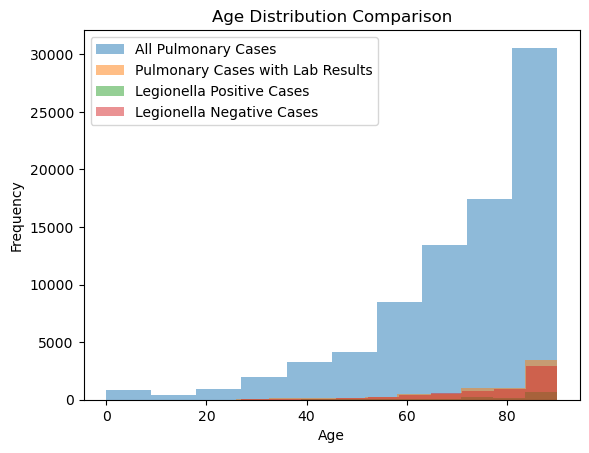

In [81]:
# Plot age distributions
plt.hist(pulmonary_patients["age"], bins=10, alpha=0.5, label="All Pulmonary Cases")
plt.hist(pulmonary_with_lab["age"], bins=10, alpha=0.5, label="Pulmonary Cases with Lab Results")
plt.hist(legionella_positive["age"], bins=10, alpha=0.5, label="Legionella Positive Cases")
plt.hist(legionella_negative["age"], bins=10, alpha=0.5, label="Legionella Negative Cases")

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.title("Age Distribution Comparison")
plt.show()


## Question 6: Characteristics of patients admitted to the hospital with legionella and those as outpatients


                 pt_id     sex  age age_bucket               enc_id  enc_year  \
0  3013939574033803906    Male   84      80-89  -240993675077899638      2020   
1 -4955299412922112414  Female   88      80-89 -6355689436869637690      2022   
2 -4955299412922112414  Female   88      80-89 -7605322012384449621      2023   
3 -4955299412922112414  Female   88      80-89  -346744282980138390      2023   
4 -4690851033038895663    Male   18      10-19 -3835475160492530654      2021   

    enc_type  hospitalized  
0  inpatient             1  
1  inpatient             1  
2  inpatient             1  
3  inpatient             1  
4  inpatient             1  
Test Result vs. Hospitalization Type:
enc_type     inpatient  outpatient
test_result                       
negative         65660         759
positive          2106          11
Chi-square test: chi2=6.621415322789939, p-value=0.010075973148509458


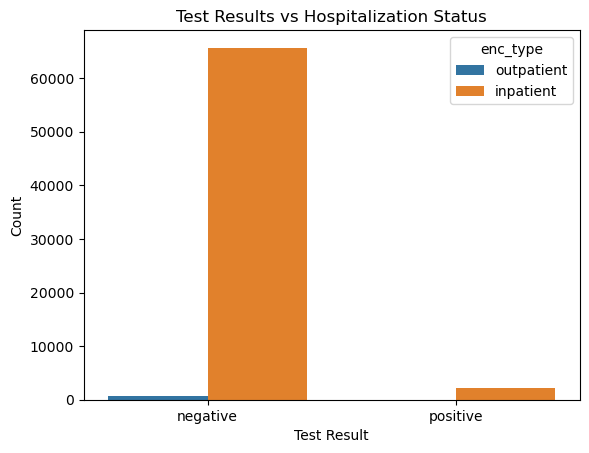

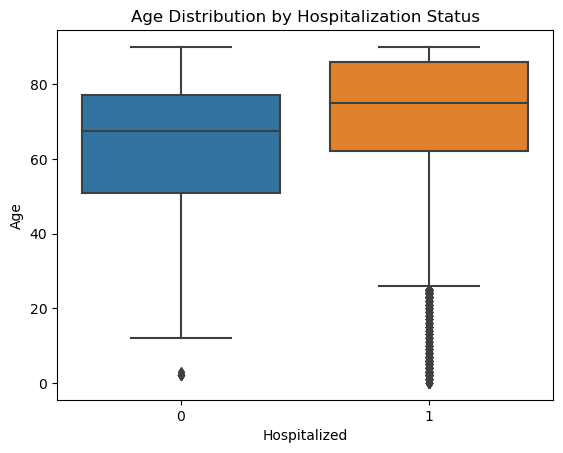

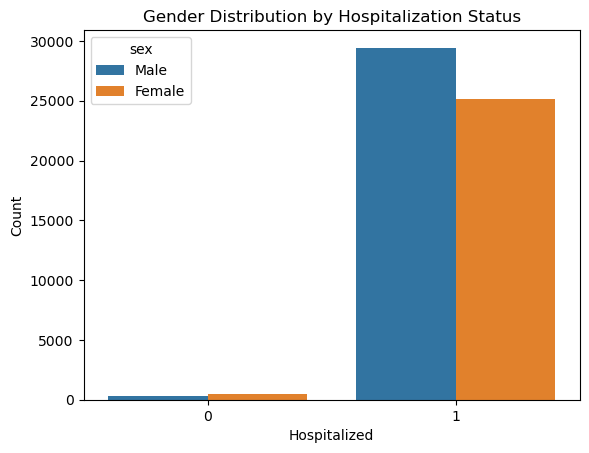

Gender vs Hospitalization - Chi2: 83.63873272101975, p-value: 5.939782555197097e-20
Odds Ratio (Male vs Female): 1.99
Optimization terminated successfully.
         Current function value: 0.070520
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           hospitalized   No. Observations:                55361
Model:                          Logit   Df Residuals:                    55359
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                 0.01475
Time:                        14:27:54   Log-Likelihood:                -3904.1
converged:                       True   LL-Null:                       -3962.5
Covariance Type:            nonrobust   LLR p-value:                 3.068e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [82]:
df_patient = pd.read_csv('cleaned_data/patient.csv')
df_encounter = pd.read_csv('cleaned_data/encounter.csv')
df_mapping = pd.read_csv('cleaned_data/enc_id_pt_id.csv')


# MERGING MAPPING FILE WITH PATIENT AND ENCOUNTER DATA
merged_patient_mapping = df_patient.merge(df_mapping, on='pt_id', how='inner')
merged_patient_enc = merged_patient_mapping.merge(df_encounter, on='enc_id', how='inner')

# MERGING TWO DATASETS
merged_patient_enc['hospitalized'] = (merged_patient_enc['enc_type'] == 'inpatient').astype(int)

print(merged_patient_enc.head())

# --------------------------------------------------------------------------------------
# 3. Legionella positivity and legionella hospitalization
df_all_results = pd.concat([
    pd.read_csv('cleaned_data/urine_antigen.csv'),
    pd.read_csv('cleaned_data/pcr.csv'),
    pd.read_csv('cleaned_data/abs.csv')
], axis=0)

merged_test_enc = df_all_results.merge(df_encounter, on='enc_id', how='inner')

test_hospitalization_summary = pd.crosstab(merged_test_enc['test_result'], merged_test_enc['enc_type'])

print("Test Result vs. Hospitalization Type:")
print(test_hospitalization_summary)

# CHI SQUARED
chi2, p, dof, expected = chi2_contingency(test_hospitalization_summary)
print(f"Chi-square test: chi2={chi2}, p-value={p}")

sns.countplot(x='test_result', hue='enc_type', data=merged_test_enc)
plt.title('Test Results vs Hospitalization Status')
plt.xlabel('Test Result')
plt.ylabel('Count')
plt.show()

# --------------------------------------------------------------------------------------
# 4. Patient characteristics associated with hospitalization vs non-hospitalization
characteristics_summary = merged_patient_enc.groupby('hospitalized').agg({
    'age': ['mean', 'std', 'min', 'max'],
    'sex': 'value_counts',
    'age_bucket': 'value_counts'
})

sns.boxplot(x='hospitalized', y='age', data=merged_patient_enc)
plt.title('Age Distribution by Hospitalization Status')
plt.xlabel('Hospitalized')
plt.ylabel('Age')
plt.show()

sns.countplot(x='hospitalized', hue='sex', data=merged_patient_enc)
plt.title('Gender Distribution by Hospitalization Status')
plt.xlabel('Hospitalized')
plt.ylabel('Count')
plt.show()

# GENDER
gender_hospitalization = pd.crosstab(merged_patient_enc['sex'], merged_patient_enc['hospitalized'])
chi2, p, dof, expected = chi2_contingency(gender_hospitalization)
print(f"Gender vs Hospitalization - Chi2: {chi2}, p-value: {p}")
odds_male = (gender_hospitalization.loc['Male', 1] / gender_hospitalization.loc['Male', 0])
odds_female = (gender_hospitalization.loc['Female', 1] / gender_hospitalization.loc['Female', 0])
odds_ratio_gender = odds_male / odds_female
print(f"Odds Ratio (Male vs Female): {odds_ratio_gender:.2f}")

# Performing a Logistic regression for age and then seeing the odd ratio
X = sm.add_constant(merged_patient_enc[['age']])
y = merged_patient_enc['hospitalized']
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())
odds_ratio_age = np.exp(logit_model.params['age'])
print(f"Odds Ratio for Age: {odds_ratio_age:.2f}")
